# Importing the necessary libraries to merge the various JSON files as well performing the data analysis & visualisation

In [1]:
import unicodedata
import os
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# Merging all the JSON files into one single dataframe

In [2]:
path = r"C:\Users\Gwenn\Desktop\Testscrape\hemnet"
files = [file for file in os.listdir(path) if file.endswith('json')] 

df = pd.DataFrame()

for file in files:
    current_data= pd.read_json(path+"/"+file)
    df = pd.concat([current_data, df])
    
df.to_csv("hemnet_data.csv", index=False)

In [3]:
df.shape
#We have 22654 rows and 11 columns in our dataframe

(23464, 11)

Checking the name of the columns - we'll have to translate that into English


In [4]:
df.keys()

Index(['address', 'typ', 'kommun', 'staden', 'rum', 'avgift', 'slutpris',
       'Pris Variation', 'datum', 'pris per sqm', 'maklare'],
      dtype='object')

# Renaming the columns from Swedish into English

In [5]:
df=df.rename(columns={
                  'address':'Address',
                  'typ':'Legal Type',
                  'kommun':'Commune',  
                  'staden':'City',
                  'rum':'Rooms',
                  'avgift':'Charge',
                  'slutpris':'Final Price',
                  'Pris Variation':'Price Variation',
                  'datum':'date',
                  'pris per sqm':'Price per sqm',
                  'maklare':'Broker'})

# Checking for null values - looks like we'll have to pay attention to 'Pris variation' in particular


In [6]:
df.isnull().sum()

Address               0
Legal Type            0
Commune               0
City                  0
Rooms                 0
Charge                0
Final Price           0
Price Variation    4764
date                  0
Price per sqm         0
Broker                0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23464 entries, 0 to 1393
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Address          23464 non-null  object
 1   Legal Type       23464 non-null  object
 2   Commune          23464 non-null  object
 3   City             23464 non-null  object
 4   Rooms            23464 non-null  object
 5   Charge           23464 non-null  object
 6   Final Price      23464 non-null  object
 7   Price Variation  18700 non-null  object
 8   date             23464 non-null  object
 9   Price per sqm    23464 non-null  object
 10  Broker           23464 non-null  object
dtypes: object(11)
memory usage: 2.1+ MB


In [8]:
df.head()

,Address,Legal Type,Commune,City,Rooms,Charge,Final Price,Price Variation,date,Price per sqm,Broker
0,Vitemöllegatan 7A,Bostadsrättslägenhet,"Östra Sorgenfri,",Malmö,51 m²\n \n 2 rum,2 916 kr/mån,Slutpris 1 220 000 kr,\n +23 %\n,Såld 15 oktober 2020,23 922 kr/m²,ERA Håkan Sköld Fastighetsbyrå
1,Ågatan 17,Bostadsrättslägenhet,"Centrum,",Enköping,81 m²\n \n 3 rum,4 228 kr/mån,Slutpris 3 135 400 kr,None,Såld 15 oktober 2020,38 709 kr/m²,Fastighetsbyrån Enköping
2,Kryddgårdsgatan 38,Bostadsrättslägenhet,"Centrum,",Enköping,93 m²\n \n 4 rum,4 854 kr/mån,Slutpris 3 879 000 kr,None,Såld 15 oktober 2020,41 710 kr/m²,Fastighetsbyrån Enköping
3,Nedre Ängsvägen - Ski Apartments nr 2,Bostadsrättslägenhet,"Kungsberget,",Sandviken,46 m²\n \n 3 rum,2 530 kr/mån,Slutpris 1 150 000 kr,None,Såld 15 oktober 2020,25 000 kr/m²,Fastighetsbyrån Sandviken
4,Nedre Ängsvägen - Kungsberget Ski Apartments n...,Bostadsrättslägenhet,"Kungsberget,",Sandviken,46 m²\n \n 3 rum,2 530 kr/mån,Slutpris 1 150 000 kr,None,Såld 15 oktober 2020,25 000 kr/m²,Fastighetsbyrån Sandviken


Let's convert all the columns into a string type to clean them more easily and then convert them into the appropriate types

In [9]:
df = df.astype(str)

# Data Cleaning

The Address field doesn't need any data cleaning - on the other hands pretty much all the other fields need some to be analysed

In [10]:
df['Commune'].unique()

array(['Östra Sorgenfri,', 'Centrum,', 'Kungsberget,', ...,
       'Stigslund, Gävle,', 'Hagastaden - Vasastan,', 'Glömsta,'],
      dtype=object)

Looks like there is an unnecessary column at the end of every commune name, we could use str.replace(',','') but many communes actually have a column as part of their names.

Given that the column is always at the very end of the name we can just use a .str[:-1] method to remove the last character

In [11]:
df['Commune']=df['Commune'].str[:-1]

In [12]:
df['Commune']

0       Östra Sorgenfri
1               Centrum
2               Centrum
3           Kungsberget
4           Kungsberget
             ...       
1389           Kallhäll
1390        Kvarnholmen
1391          Kungshöjd
1392          Södermalm
1393      Sörby/Eklunda
Name: Commune, Length: 23464, dtype: object

Quite a few columns such as 'Price per sqm', 'Charge', 'Final Price' have similar unwanted characters
so let's use a foor loop to remove them all at once.

In [13]:
characters=['m²','\xa0','rum','kr','mån','Slutpris',r'\W']
columns=['Price per sqm','Charge','Final Price']
for column in columns:
    for character in characters:
        df[column]=df[column].str.replace(character,'')

Let's have a look at the 'Rooms'Looks like the \n are unnecessary here let's use the .str.replace method to get rid of them 

In [14]:
df['Rooms']=df['Rooms'].str.replace('\n','')

It also looks like we have different bits of information in the same column, on the left hand side we've got the square meters
(to the left of m2) and the number of rooms (number to the left of rum)

In [15]:
df['Rooms']

0         51 m²                       2 rum
1         81 m²                       3 rum
2         93 m²                       4 rum
3         46 m²                       3 rum
4         46 m²                       3 rum
                       ...                 
1389      50 m²                       2 rum
1390      38 m²                       1 rum
1391     144 m²                       4 rum
1392    75,5 m²                       3 rum
1393      53 m²                       2 rum
Name: Rooms, Length: 23464, dtype: object

# Let's define a couple of functions to grab the appropriate data, get rid of the unwanted characters and create a separate column for Square Meters

In [16]:
#The first function will be to grab the integers to the left of m² in order to create the Square Meters function
def get_sqm2(element):
    return element.split('m²')[0]

#The second function will be slicing the column to grab the elements at the very right of the column and get rid of the unnecessary space
def get_rooms(element):
    element=element[10:-3]
    element=element.strip(' ')
    return element

In [17]:
df['Square Meters']=df['Rooms'].apply(lambda x: get_sqm2(x))

In [18]:
df['Square Meters']

0         51 
1         81 
2         93 
3         46 
4         46 
        ...  
1389      50 
1390      38 
1391     144 
1392    75,5 
1393      53 
Name: Square Meters, Length: 23464, dtype: object

In [19]:
df['Rooms']=df['Rooms'].apply(lambda x: get_rooms(x))

In [20]:
df['Rooms']

0                    2 
1                    3 
2                    4 
3                    3 
4                    3 
             ...       
1389                 2 
1390                 1 
1391                 4 
1392                 3 
1393                 2 
Name: Rooms, Length: 23464, dtype: object

A few records have no 'Rooms' data assigned to them

In [21]:
df[df['Rooms']=='']

,Address,Legal Type,Commune,City,Rooms,Charge,Final Price,Price Variation,date,Price per sqm,Broker,Square Meters
874,Maria Prästgårdsgata 14,Bostadsrättslägenhet,Södermalm,Stockholm,,4319,10150000,None,Såld 25 september 2020,106842,Mäklarhuset Stockholm Innerstan,95
228,Södra esplanaden 13A,Bostadsrättslägenhet,Lund - Centrum,Lund,,2065,2150000,\n +3 %\n,Såld 5 augusti 2020,79630,Bjurfors Lund Centrum,27
287,Turbingatan 1 A,Bostadsrättslägenhet,Märsta Industriområde,Sigtuna,,5828,2800000,None,Såld 4 augusti 2020,15730,Mäklarhuset Sigtuna Märsta Rosersberg,178
605,Klingagatan 1,Bostadsrättslägenhet,Skarphagen,Norrköping,,1686,715000,None,Såld 29 juli 2020,23443,Östgöta Fastighetsmäklare,"30,5"
678,Vasagatan 14C,Bostadsrättslägenhet,Dagny,Borlänge,,1456,555000,\n +23 %\n,Såld 9 december 2020,15857,Länsförsäkringar Fastighetsförmedling Borlänge,35
39,Vasagatan 14C,Bostadsrättslägenhet,Dagny,Borlänge,,1456,555000,\n +23 %\n,Såld 9 december 2020,15857,Länsförsäkringar Fastighetsförmedling Borlänge,35
79,Slottsvägen 32,Bostadsrättslägenhet,Näsbypark,Täby,,5213,450000,\n +50 %\n,Såld 13 januari 2021,4500,Bjurfors Täby Danderyd,100
397,Vikingagatan 24,Bostadsrättslägenhet,Vasastan - Birkastan,Stockholm,,991,3200000,\n +15 %\n,Såld 17 oktober 2020,113475,Bjurfors Vasastan Kungsholmen,"28,2"
33,Skogsmilsgatan 13,Bostadsrättslägenhet,Högsbo - Kaverös,Göteborg,,3673,2300000,\n +10 %\n,Såld 18 november 2020,40000,Bjurfors Väster,"57,5"
1139,Solhagavägen 12,Bostadsrättslägenhet,Falkagård,Falkenberg,,6805,330000,\n -12 %\n,Såld 9 november 2020,3905,Svensk Fastighetsförmedling Falkenberg,"84,5"


Let's drop them as they might skew our data analysis

In [22]:
df=df[df['Rooms']!='']

Now we need to convert both 'Rooms' and 'Square meters' into floats. 
Given we need to perform the same operation more than once we'll use a foor loop

In [23]:
columns=['Rooms','Square Meters']
for column in columns:
    df[column]=df[column].astype(str)
    df[column]=df[column].str.replace(',','.')
    df[column]=df[column].astype(float)


Let's take care of the Price Variation column - we'll replace the None Values by 0 given it indicates a lack of price increase/decrease

In [24]:
df['Price Variation'].unique()

array(['\n      +23\xa0%\n    ', 'None', '\n      +30\xa0%\n    ',
       '\n      +8\xa0%\n    ', '\n      -1\xa0%\n    ',
       '\n      +7\xa0%\n    ', '\n      +19\xa0%\n    ',
       '\n      -3\xa0%\n    ', '\n      +37\xa0%\n    ',
       '\n      -2\xa0%\n    ', '\n      +10\xa0%\n    ',
       '\n      \n    ', '\n      +27\xa0%\n    ',
       '\n      +20\xa0%\n    ', '\n      +26\xa0%\n    ',
       '\n      +16\xa0%\n    ', '\n      +6\xa0%\n    ',
       '\n      +1\xa0%\n    ', '\n      +12\xa0%\n    ',
       '\n      -4\xa0%\n    ', '\n      +18\xa0%\n    ',
       '\n      +3\xa0%\n    ', '\n      +2\xa0%\n    ',
       '\n      +14\xa0%\n    ', '\n      +24\xa0%\n    ',
       '\n      +28\xa0%\n    ', '\n      -6\xa0%\n    ',
       '\n      +4\xa0%\n    ', '\n      +9\xa0%\n    ',
       '\n      +13\xa0%\n    ', '\n      -5\xa0%\n    ',
       '\n      +34\xa0%\n    ', '\n      +17\xa0%\n    ',
       '\n      +31\xa0%\n    ', '\n      -8\xa0%\n    ',
       '\n  

In [25]:
characters=['\xa0%\n','None',' ','\n']
for character in characters:
    df['Price Variation']=df['Price Variation'].str.replace(character,'')

In [26]:
df['Price Variation'].unique()

array(['+23', '', '+30', '+8', '-1', '+7', '+19', '-3', '+37', '-2',
       '+10', '+27', '+20', '+26', '+16', '+6', '+1', '+12', '-4', '+18',
       '+3', '+2', '+14', '+24', '+28', '-6', '+4', '+9', '+13', '-5',
       '+34', '+17', '+31', '-8', '+11', '+32', '+5', '+29', '+15', '+38',
       '+25', '+36', '-13', '+21', '+22', '+43', '+46', '+41', '-7',
       '+35', '-10', '+39', '-11', '+42', '+186', '-16', '+40', '-9',
       '+176', '-19', '-90', '+44', '+33', '+59', '+62', '+74', '-15',
       '-12', '+73', '-23', '+60', '+45', '+80', '-14', '+76', '-18',
       '+64', '-17', '+54', '+47', '+49', '+53', '+51', '+63', '+118',
       '+111', '-21', '+58', '+70', '-25', '+57', '+79', '+61', '-27',
       '+65', '+90', '-28', '+52', '-33', '+66', '-22', '+69', '+77',
       '+96', '+48', '+71', '-20', '+88', '+100', '+105', '-31', '+67',
       '+55', '+50', '+75', '-24'], dtype=object)

In [27]:
df['Price Variation']=df['Price Variation'].replace(r'\s+',np.nan,regex=True).replace('',np.nan)

In [28]:
df['Price Variation']=df['Price Variation'].apply(pd.to_numeric, errors='ignore').fillna(0)

In [29]:
df['Price Variation'].unique()


array([ 23.,   0.,  30.,   8.,  -1.,   7.,  19.,  -3.,  37.,  -2.,  10.,
        27.,  20.,  26.,  16.,   6.,   1.,  12.,  -4.,  18.,   3.,   2.,
        14.,  24.,  28.,  -6.,   4.,   9.,  13.,  -5.,  34.,  17.,  31.,
        -8.,  11.,  32.,   5.,  29.,  15.,  38.,  25.,  36., -13.,  21.,
        22.,  43.,  46.,  41.,  -7.,  35., -10.,  39., -11.,  42., 186.,
       -16.,  40.,  -9., 176., -19., -90.,  44.,  33.,  59.,  62.,  74.,
       -15., -12.,  73., -23.,  60.,  45.,  80., -14.,  76., -18.,  64.,
       -17.,  54.,  47.,  49.,  53.,  51.,  63., 118., 111., -21.,  58.,
        70., -25.,  57.,  79.,  61., -27.,  65.,  90., -28.,  52., -33.,
        66., -22.,  69.,  77.,  96.,  48.,  71., -20.,  88., 100., 105.,
       -31.,  67.,  55.,  50.,  75., -24.])

We can see there is still one value '' that needs to be converted to an integer

In [30]:
def price_transformation(column):
    df[column]=df[column].replace(r'\s+',np.nan,regex=True).replace('',np.nan)
    return column

In [31]:
price_transformation('Price Variation')

'Price Variation'

In [32]:
df['Price Variation'].astype(int)

0       23
1        0
2        0
3        0
4        0
        ..
1389     0
1390     1
1391     8
1392     1
1393    42
Name: Price Variation, Length: 23454, dtype: int32

Let's take care of the Date column now

In [33]:
df['date']

0        Såld 15 oktober 2020
1        Såld 15 oktober 2020
2        Såld 15 oktober 2020
3        Såld 15 oktober 2020
4        Såld 15 oktober 2020
                ...          
1389    Såld  3 november 2020
1390    Såld  3 november 2020
1391    Såld  3 november 2020
1392    Såld  3 november 2020
1393    Såld  3 november 2020
Name: date, Length: 23454, dtype: object

In [34]:
df['date']=df['date'].str.replace('Såld','')

In [35]:
repl = ['juli','augusti','Augusti','september','oktober','november','december','januari'], ['July','August','August','September','October','November','December','January']
for a, b in zip(*repl):
    df['date']= df['date'].str.replace(a, b)

In [36]:
df['date']

0         15 October 2020
1         15 October 2020
2         15 October 2020
3         15 October 2020
4         15 October 2020
              ...        
1389      3 November 2020
1390      3 November 2020
1391      3 November 2020
1392      3 November 2020
1393      3 November 2020
Name: date, Length: 23454, dtype: object

In [37]:
df['date']=pd.to_datetime(df['date'])

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23454 entries, 0 to 1393
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Address          23454 non-null  object        
 1   Legal Type       23454 non-null  object        
 2   Commune          23454 non-null  object        
 3   City             23454 non-null  object        
 4   Rooms            23454 non-null  float64       
 5   Charge           23454 non-null  object        
 6   Final Price      23454 non-null  object        
 7   Price Variation  23454 non-null  float64       
 8   date             23454 non-null  datetime64[ns]
 9   Price per sqm    23454 non-null  object        
 10  Broker           23454 non-null  object        
 11  Square Meters    23454 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 2.3+ MB


In [39]:
convert_to_int=['Final Price','Price per sqm']
for column in convert_to_int:
    df[column]=df[column].astype(int)

In [40]:
df['City'].unique()

array(['Malmö', 'Enköping', 'Sandviken', 'Ystad', 'Luleå', 'Stockholm',
       'Knivsta', 'Vellinge', 'Mölndal', 'Sigtuna', 'Järfälla',
       'Upplands Väsby', 'Nacka', 'Solna', 'Karlstad', 'Göteborg',
       'Norrtälje', 'Östersund', 'Bollnäs', 'Sollentuna', 'Linköping',
       'Lomma', 'Haninge', 'Gävle', 'Halmstad', 'Hedemora', 'Jönköping',
       'Örebro', 'Lund', 'Härryda', 'Uppsala', 'Huddinge', 'Kungsbacka',
       'Sundbyberg', 'Avesta', 'Karlskoga', 'Hudiksvall', 'Täby', 'Ale',
       'Ljungby', 'Nykvarn', 'Helsingborg', 'Nyköping', 'Uddevalla',
       'Umeå', 'Tyresö', 'Trelleborg', 'Falun', 'Hässleholm', 'Växjö',
       'Borås', 'Kristianstad', 'Västerås', 'Kungälv', 'Sundsvall',
       'Staffanstorp', 'Lidingö', 'Värmdö', 'Vännäs', 'Orust',
       'Falköping', 'Landskrona', 'Gotland', 'Härnösand', 'Hallstahammar',
       'Upplands-Bro', 'Svedala', 'Botkyrka', 'Kristinehamn', 'Heby',
       'Partille', 'Mora', 'Götene', 'Håbo', 'Norrköping', 'Södertälje',
       'Älvkarleby

# Importing the 'List of municipalities of Sweden' dataset from Wikipedia to add more data to our existing dataset such as County, Population and Density (people/km2)

In [41]:
municipalities=pd.read_excel('Desktop\Data Material/Municipalities in Sweden.xlsx')

Formating both dataframes a bit more to facilitate the merging

In [42]:
municipalities['City']=municipalities['City'].astype(str)

In [43]:
municipalities['City']=municipalities['City'].str.strip(' ')

In [44]:
repl=['Gothenburg','Malung','Väsby'],['Göteborg','Malung-Sälen','Upplands Väsby']
for a,b in zip(*repl):
    df['City']=df['City'].str.replace(a,b)

In [45]:
df_updated=pd.merge(df,municipalities,on='City',how='left')

In [46]:
df=df_updated

In [47]:
df['Month']=df['date'].dt.month

# Removing duplicates by address 

In [48]:
df=df.drop_duplicates(subset='Address')

In [55]:
df['Broker'].nunique()

1111

# Merging and standardising the brokers together

In [52]:
print(df['Broker'].unique())

['ERA Håkan Sköld Fastighetsbyrå' 'Fastighetsbyrån Enköping'
 'Fastighetsbyrån Sandviken' ... 'Mäklarhuset Solna Sundbyberg'
 'Mäklarhuset Ängelholm' 'Mäklarhuset Vaggeryd']


In [87]:
brokers=['SkandiaMäklarna','Fastighetsbyrån','Svensk Fastighetsförmedling','Mäklarhuset','Svenska Mäklarhuse','Länsförsäkringar Fastighetsförmedling',
        'Bjurfors','Länsförsäkringar Fastighetsförmedling','HusmanHagberg','Eklund','Mäklarringen','MOHV',
         'BOSTHLM','Erik Olsson','Våningen & Villan','ERA','Widerlöv']
for broker in brokers:
    df['Broker']=np.where(df['Broker'].str.contains(broker),broker,df['Broker'])

C:\Users\Gwenn\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Uploading the updated dataset into an excel file

In [95]:
df.to_excel('Updated Hemnet Dataset.xlsx')

# Data Visualisation

(array([-25000.,      0.,  25000.,  50000.,  75000., 100000., 125000.,
        150000., 175000., 200000., 225000.]),
 <a list of 11 Text yticklabel objects>)

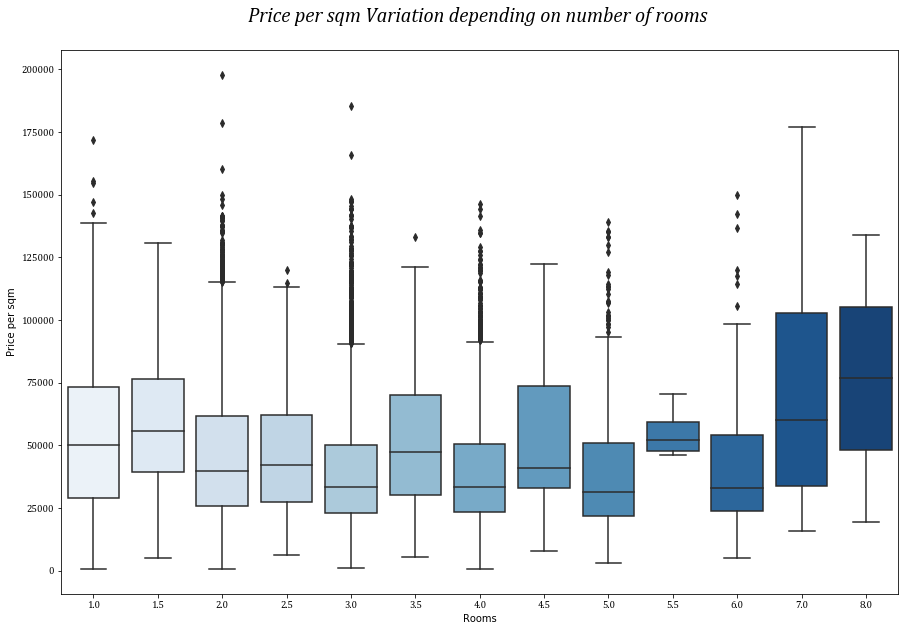

In [96]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Rooms',y='Price per sqm',data=df,palette='Blues')
plt.title('Price per sqm Variation depending on number of rooms \n',fontname='Cambria',fontsize=20,fontstyle='italic')
plt.xticks(fontname='Cambria')
plt.yticks(fontname='Cambria')

In [97]:
rolling_avg=df.groupby('date').count()['Address'].rolling(window=30).mean().reset_index()

Text(0, 0.5, 'Total Transactions \n')

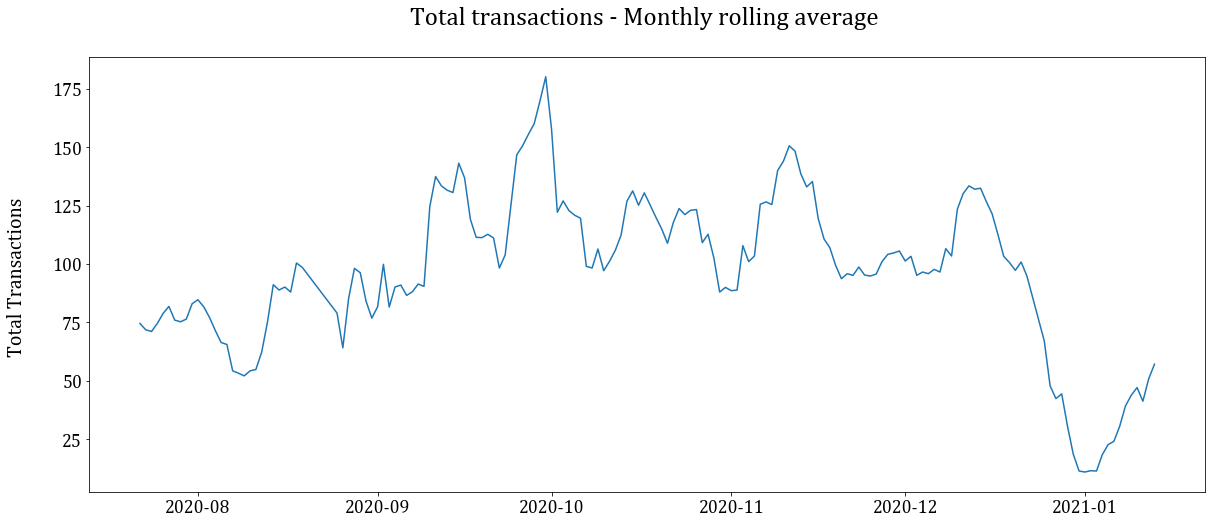

In [115]:
plt.figure(figsize=(20,8))
plt.title('Total transactions - Monthly rolling average \n',fontsize=25,fontname='Cambria')
sns.lineplot(x='date',y='Address',data=rolling_avg,)
plt.xticks(rotation=0,fontsize=18,fontname='Cambria')
plt.yticks(rotation=0,fontsize=18,fontname='Cambria')
plt.xlabel('')
plt.ylabel('Total Transactions \n',fontsize=20,fontname='Cambria')

In [99]:
top_3_counties=['Stockholm County','Skåne County','Västra Götaland County']

In [100]:
top_3=df.loc[(df['County']=='Stockholm County') | (df['County']=='Skåne County') | (df['County']=='Västra Götaland County')]

In [101]:
top_3

,Address,Legal Type,Commune,City,Rooms,Charge,Final Price,Price Variation,date,Price per sqm,...,Code,Seat,County,Population,Total area (km2),Land area (km2),Inland water area (km2),Seawater area (km2),Density (people/km2),Month
0,Vitemöllegatan 7A,Bostadsrättslägenhet,Östra Sorgenfri,Malmö,2.0,2916,1220000,23.0,2020-10-15,23922,...,1280.0,Malmö,Skåne County,336226.0,332.64,156.87,1.52,174.25,1985.98,10
5,Björnstjernegatan 2 lgh 1104,Bostadsrättslägenhet,Regementet,Ystad,3.0,7838,4990000,0.0,2020-10-15,30427,...,1286.0,Ystad,Skåne County,28593.0,1189.32,350.08,5.02,834.22,81.68,10
6,Björnstjernegatan 2 lgh 1105,Bostadsrättslägenhet,Regementet,Ystad,3.0,5638,3330000,0.0,2020-10-15,31415,...,1286.0,Ystad,Skåne County,28593.0,1189.32,350.08,5.02,834.22,81.68,10
7,Björnstjernegatan 2 lgh 1103,Bostadsrättslägenhet,Regementet,Ystad,4.0,6404,3610000,0.0,2020-10-15,29113,...,1286.0,Ystad,Skåne County,28593.0,1189.32,350.08,5.02,834.22,81.68,10
8,Björnstjernegatan 2 lgh 1006,Bostadsrättslägenhet,Regementet,Ystad,2.0,4520,2210000,0.0,2020-10-15,26951,...,1286.0,Ystad,Skåne County,28593.0,1189.32,350.08,5.02,834.22,81.68,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23435,Måltemyrsvägen 13 A,Bostadsrättslägenhet,Äsperöd,Uddevalla,3.0,3634,1175000,-9.0,2020-11-03,16096,...,1485.0,Uddevalla,Västra Götaland County,52886.0,733.03,637.69,12.60,82.74,82.93,11
23436,"Sonja Kovalevskys Gata 3, 8 tr",Bostadsrättslägenhet,Hagastaden - Vasastan,Stockholm,2.0,1750,3875000,14.0,2020-11-03,110714,...,180.0,Stockholm,Stockholm County,955397.0,214.63,187.17,4.95,6.79,4777.29,11
23438,"Centralvägen 3, 4 tr",Bostadsrättslägenhet,Solna C,Solna,3.0,3974,4250000,4.0,2020-11-03,51205,...,184.0,Solna (Skytteholm),Stockholm County,72495.0,21.66,19.30,1.18,0.65,3756.22,11
23440,Sankt Eriksvägen 16F,Bostadsrättslägenhet,Glömsta,Huddinge,2.0,2177,1900000,2.0,2020-11-03,55882,...,126.0,Huddinge,Stockholm County,102256.0,140.63,131.01,8.13,0.00,780.52,11


(array([      0.,  500000., 1000000., 1500000., 2000000., 2500000.,
        3000000., 3500000., 4000000., 4500000.]),
 <a list of 10 Text yticklabel objects>)

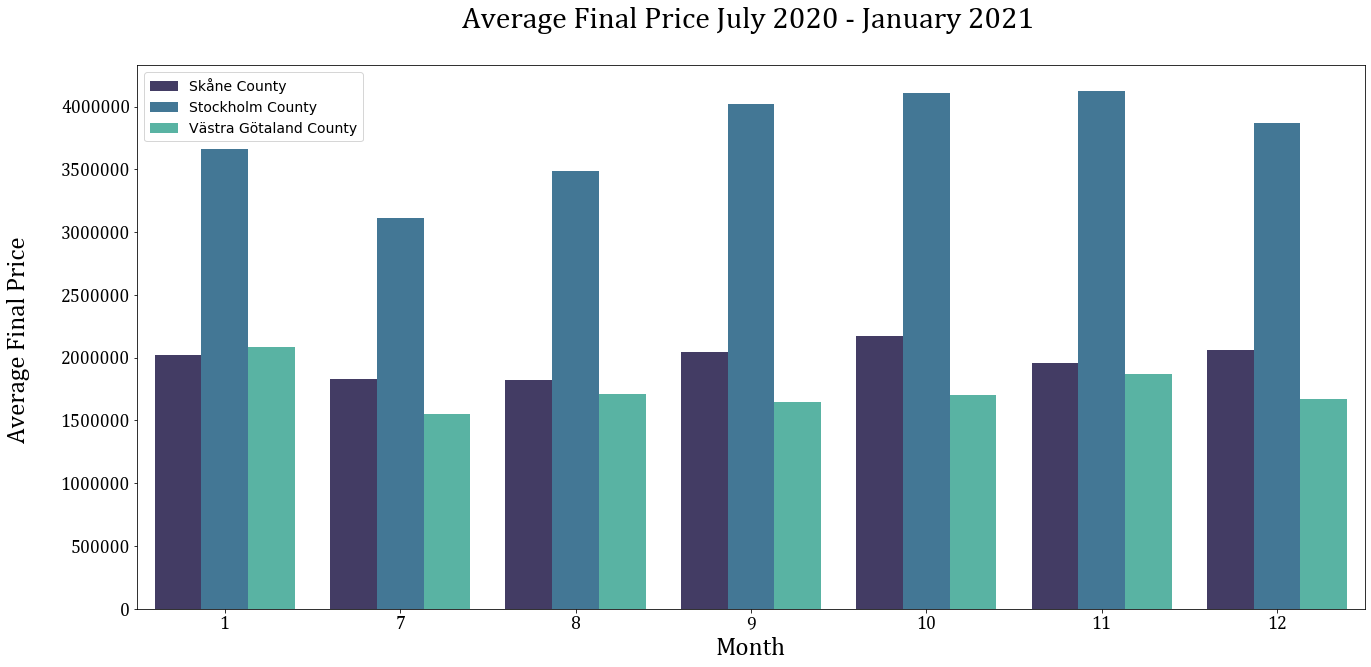

In [102]:
plt.figure(figsize=(22,10))
plt.title('Average Final Price July 2020 - January 2021 \n',fontsize=30,fontname='Cambria')
sns.barplot(x='Month',y='Final Price',data=top_3,hue='County',palette='mako',estimator=np.mean,ci=None)
plt.legend(fontsize=14)
plt.xticks(rotation=0,fontsize=18,fontname='Cambria')
plt.xlabel('Month',fontsize=25,fontname='Cambria')

plt.ylabel('Average Final Price \n',fontsize=25,fontname='Cambria')
plt.yticks(rotation=0,fontsize=18,fontname='Cambria')

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 <a list of 8 Text yticklabel objects>)

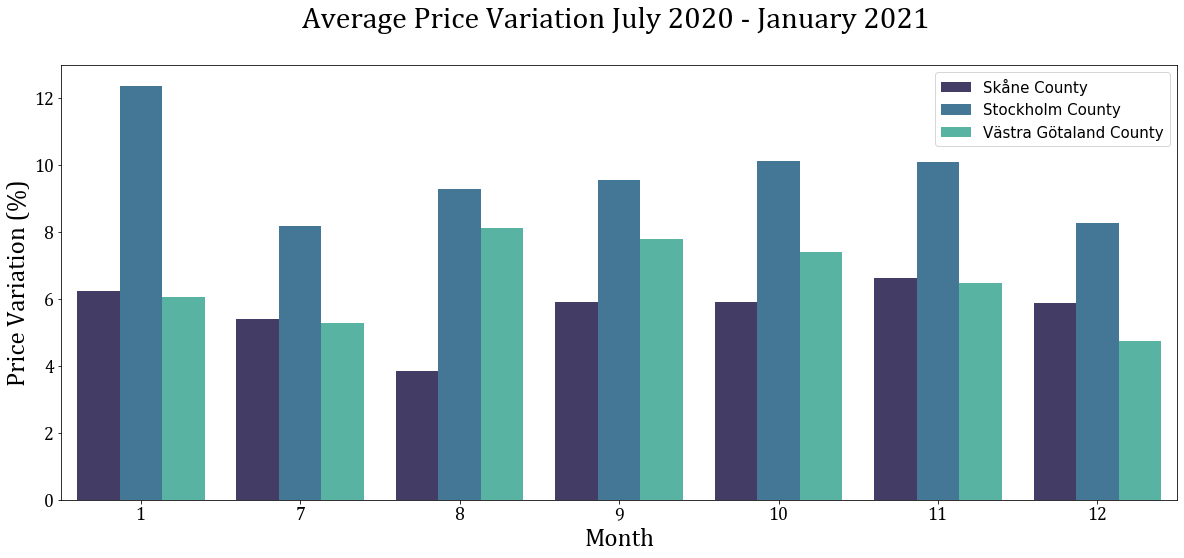

In [103]:
plt.figure(figsize=(20,8))
plt.title('Average Price Variation July 2020 - January 2021 \n',fontsize=30,fontname='Cambria')
sns.barplot(x='Month',y='Price Variation',data=top_3,hue='County',palette='mako',estimator=np.mean,ci=None)
plt.legend(fontsize=15)
plt.xticks(rotation=0,fontsize=18,fontname='Cambria')
plt.xlabel('Month',fontsize=25,fontname='Cambria')

plt.ylabel('Price Variation (%)',fontsize=25,fontname='Cambria')
plt.yticks(rotation=0,fontsize=18,fontname='Cambria')

In [113]:
final_price_rolling=df.groupby('date').mean()['Final Price'].rolling(window=30).mean().reset_index()

Text(0, 0.5, '')

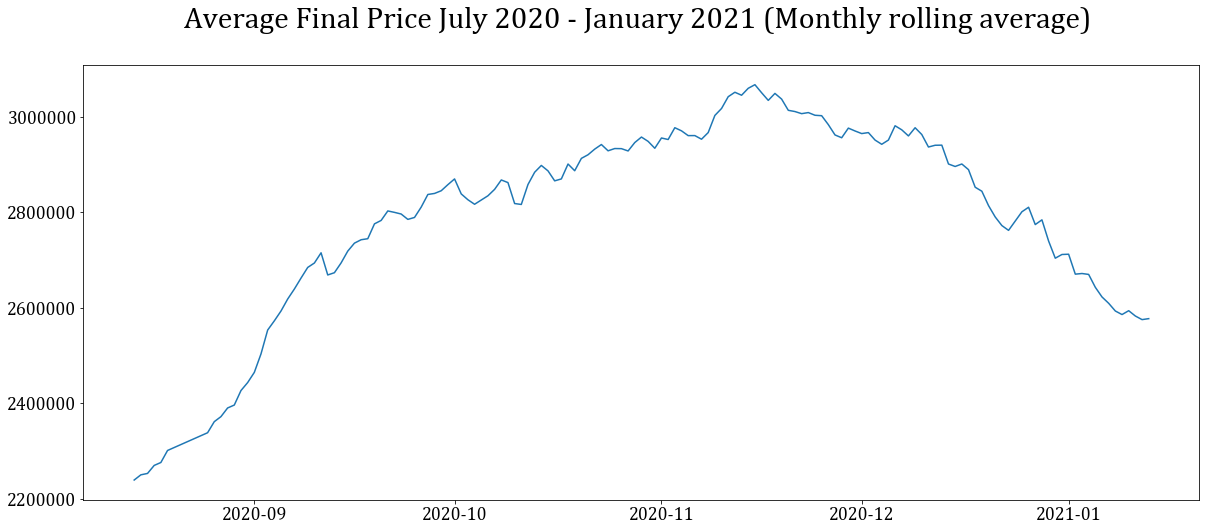

In [116]:
plt.figure(figsize=(20,8))
plt.title('Average Final Price July 2020 - January 2021 (Monthly rolling average) \n',fontsize=30,fontname='Cambria')
sns.lineplot(x='date',y='Final Price',data=final_price_rolling)
plt.xticks(rotation=0,fontsize=18,fontname='Cambria')
plt.yticks(rotation=0,fontsize=18,fontname='Cambria')
plt.xlabel('')
plt.ylabel('')

In [106]:
df.groupby('date').mean()['Final Price'].rolling(window=7).mean()

date
2020-07-16             NaN
2020-07-17             NaN
2020-07-18             NaN
2020-07-19             NaN
2020-07-20             NaN
                  ...     
2021-01-09    2.643234e+06
2021-01-10    2.711515e+06
2021-01-11    2.676185e+06
2021-01-12    2.767843e+06
2021-01-13    2.772271e+06
Name: Final Price, Length: 176, dtype: float64

In [107]:
top_3_rolling=top_3.groupby(['date','County']).mean()['Final Price'].rolling(window=30).mean().reset_index()

Text(0, 0.5, '')

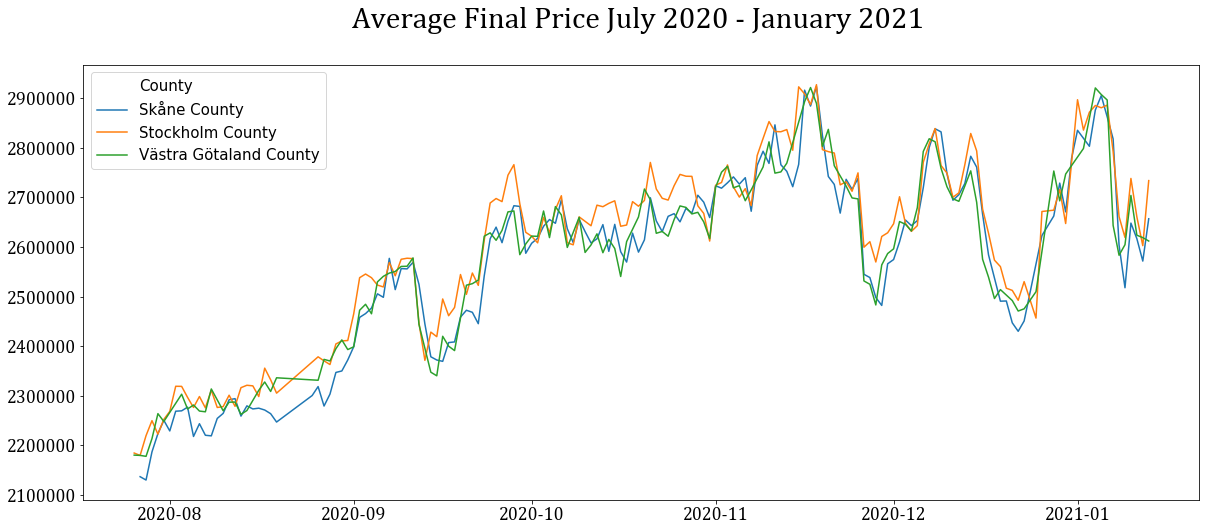

In [108]:
plt.figure(figsize=(20,8))
plt.title('Average Final Price July 2020 - January 2021 \n',fontsize=30,fontname='Cambria')
sns.lineplot(x='date',y='Final Price',data=top_3_rolling,hue='County')
plt.xticks(rotation=0,fontsize=18,fontname='Cambria')
plt.yticks(rotation=0,fontsize=18,fontname='Cambria')
plt.legend(fontsize=15)
plt.xlabel('')
plt.ylabel('')

In [128]:
brokers_df=df.groupby('Broker').sum()['Final Price'].sort_values(ascending=False).head(10).reset_index()


(array([0.e+00, 1.e+09, 2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09,
        8.e+09, 9.e+09]),
 <a list of 10 Text xticklabel objects>)

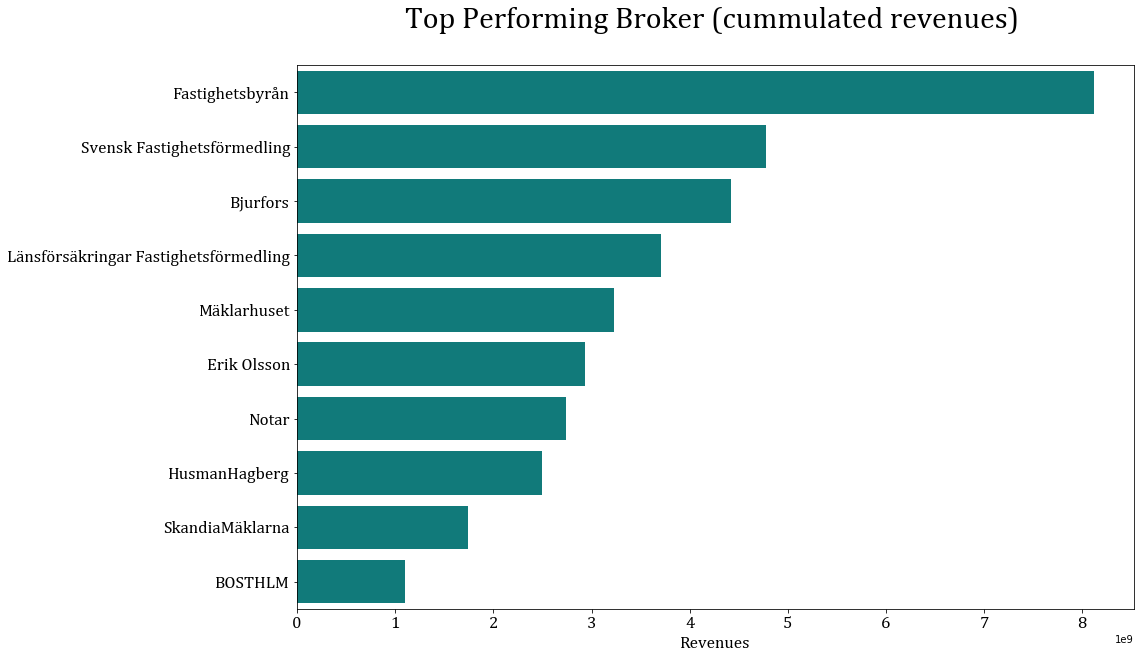

In [156]:
plt.figure(figsize=(15,10))
plt.title('Top Performing Broker (cummulated revenues) \n',fontname='Cambria',fontsize=30)
sns.barplot(x='Final Price',y='Broker',data=brokers_df,color='darkcyan')
plt.ylabel('')
plt.xlabel('Revenues',fontname='Cambria',fontsize=17)

plt.yticks(fontname='Cambria',fontsize=17)
plt.xticks(fontname='Cambria',fontsize=17)
